In [397]:
import pandas
import numpy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import nltk

In [398]:
data = pandas.read_csv('dump.csv', delimiter=',', encoding='latin-1')
data[:5]

,ermi,event_type,incident_description,descriptor,coordinator_comments,investigation_narrative,acute_medical_harm,dosimetric_impact,latent_medical_harm,functional_work_area,...,number_fractions_prescribed,number_fractions_incorrect,hardware_manufacturer_model,software_manufacturer_model,body_region_treated,treatment_intent,ameliorating_actions,safety_barriers_failed,safety_barriers_prevented,actions_reduce_risk
0,2511,Actual incident,Bolus was not prescribed by MD. Pt received 2 ...,Non prescribed bolus,NaN,NaN,None,Minor,No,TrueBeam 3,...,25.0,2.0,NaN,NaN,Thorax,NaN,Other,Verification of treatment accessories,NaN,NaN
1,2521,Actual incident,Noticed by nutistionist (pt had app. with supp...,skin breakdown post RT,NaN,I handed over the investigation of incident to...,Mild,None,Unknown,STx 1,...,25.0,0.0,NaN,NaN,Head and neck,Curative (Radical),NaN,NaN,NaN,NaN
2,2562,Actual incident,"Ready for treatment task sent,completed,howeve...",Call patient task never sent,NaN,NaN,None,None,Unknown,STx 2,...,10.0,0.0,NaN,NaN,Thorax,Curative (Radical),Staff debriefing or counselling,Time out/verbalization/call-back,NaN,Improved compliance with existing policies or ...
3,2560,Near miss,"Physics QA completed, but ready for treatment ...",ready for treatment tasking error,NaN,tasking error,NaN,NaN,NaN,Tasking,...,25.0,NaN,NaN,NaN,Thorax,Curative (Radical),Education or training,Verification of relevant clinical information,Verification of relevant clinical information,Process standardization
4,2526,Near miss,Typo in prescription document. It was prescrib...,prescription error,NaN,NaN,NaN,NaN,NaN,STx 2,...,5.0,NaN,NaN,NaN,NaN,NaN,Other,None,Independent confirmation of dose,NaN


In [399]:
data['near_miss'] = data['event_type'].apply(lambda x: 1 if x=='Near miss' else 0)
data

,ermi,event_type,incident_description,descriptor,coordinator_comments,investigation_narrative,acute_medical_harm,dosimetric_impact,latent_medical_harm,functional_work_area,...,number_fractions_incorrect,hardware_manufacturer_model,software_manufacturer_model,body_region_treated,treatment_intent,ameliorating_actions,safety_barriers_failed,safety_barriers_prevented,actions_reduce_risk,near_miss
0,2511,Actual incident,Bolus was not prescribed by MD. Pt received 2 ...,Non prescribed bolus,NaN,NaN,None,Minor,No,TrueBeam 3,...,2.0,NaN,NaN,Thorax,NaN,Other,Verification of treatment accessories,NaN,NaN,0
1,2521,Actual incident,Noticed by nutistionist (pt had app. with supp...,skin breakdown post RT,NaN,I handed over the investigation of incident to...,Mild,None,Unknown,STx 1,...,0.0,NaN,NaN,Head and neck,Curative (Radical),NaN,NaN,NaN,NaN,0
2,2562,Actual incident,"Ready for treatment task sent,completed,howeve...",Call patient task never sent,NaN,NaN,None,None,Unknown,STx 2,...,0.0,NaN,NaN,Thorax,Curative (Radical),Staff debriefing or counselling,Time out/verbalization/call-back,NaN,Improved compliance with existing policies or ...,0
3,2560,Near miss,"Physics QA completed, but ready for treatment ...",ready for treatment tasking error,NaN,tasking error,NaN,NaN,NaN,Tasking,...,NaN,NaN,NaN,Thorax,Curative (Radical),Education or training,Verification of relevant clinical information,Verification of relevant clinical information,Process standardization,1
4,2526,Near miss,Typo in prescription document. It was prescrib...,prescription error,NaN,NaN,NaN,NaN,NaN,STx 2,...,NaN,NaN,NaN,NaN,NaN,Other,None,Independent confirmation of dose,NaN,1
5,2513,Actual incident,Started patient's treatments on a Friday inste...,New Start on Friday,NaN,NaN,None,None,Unknown,STx 1,...,2.0,NaN,NaN,Head and neck,Curative (Radical),Staff debriefing or counselling & Education or...,Verification of relevant clinical information ...,NaN,Reminder(s) or checklist(s) & Improved complia...,0
6,2570,Actual incident,Pt was treated on TB 6on Feb 1st due to Tb3 be...,Lost vacloc,NaN,NaN,None,Minor,No,TrueBeam 6,...,0.0,NaN,NaN,Thorax,Curative (Radical),Education or training,None,None,Leadership action - Culture change & Staff rem...,0
7,2518,Near miss,Bolus not prescibed,Bolus,NaN,NaN,NaN,NaN,NaN,TrueBeam 3,...,NaN,NaN,NaN,Thorax,Curative (Radical),Radiation treatment plan revision,Oncologist review of treatment plan,Verification of treatment accessories,Additional education or training,1
8,2543,Actual incident,"Patient was lost(forgotten) in system, plan re...",Lack of adequate planning time.,NaN,patient lost in process,None,None,No,Treatment Planning,...,NaN,NaN,NaN,NaN,NaN,Education or training,Other,NaN,Process standardization,0
9,2541,Actual incident,Oncologist complained why patient was not cont...,Tasking Error,NaN,tasking error,None,None,No,Treatment Planning,...,NaN,NaN,NaN,NaN,NaN,Education or training,Verification of relevant clinical information,Verification of relevant clinical information,Process standardization,0


In [400]:
tokenized_entries = [entry.split(' ') for entry in data['incident_description']]
punctuation = [",", ":", ";", ".", "'", '"', "’", "?", "/", "-", "+", "&", "(", ")"]

def clean(token):
    token = token.lower()
    for punc in punctuation:
        if punc in token:
            token = token.replace(punc, '')
    return token

cleaned_entries = [[clean(word) for word in entry] for entry in tokenized_entries]
cleaned_entries[:30]

[['bolus',
  'was',
  'not',
  'prescribed',
  'by',
  'md',
  'pt',
  'received',
  '2',
  'treatments',
  'wothout',
  'bolus'],
 ['noticed',
  'by',
  'nutistionist',
  'pt',
  'had',
  'app',
  'with',
  'support',
  'group',
  'that',
  'patient',
  'needed',
  'to',
  'be',
  'evaluated',
  'for',
  'skin',
  'reaction',
  'pt',
  'not',
  'assessed',
  'by',
  'rn',
  'on',
  'last',
  'day',
  'of',
  'treatment',
  'patient',
  'noticed',
  'after',
  'her',
  'treatments',
  'were',
  'completed',
  'that',
  'her',
  'skin',
  'broke',
  'down',
  'she',
  'tried',
  'to',
  'contact',
  'trwatment',
  'unit',
  'andor',
  'rad',
  'onc',
  'on',
  'call',
  'with',
  'no',
  'success',
  'pt',
  'even',
  'presented',
  'herself',
  'x1',
  'but',
  'left',
  'due',
  'to',
  'lenghty',
  'wait',
  'time'],
 ['ready',
  'for',
  'treatment',
  'task',
  'sentcompletedhowever',
  'call',
  'patient',
  'task',
  'never',
  'sent',
  'delay',
  '1',
  'day'],
 ['physics',
  '

In [401]:
unique_words = list(set([word for entry in cleaned_entries for word in entry]))
unique_words[:30]

['',
 'asap',
 'lung',
 'shoulderposition',
 'zofran',
 'compatible',
 'developed',
 'catheters',
 'rescan',
 'single',
 'am',
 'pressing',
 'quality',
 '0644787',
 'able',
 'redo',
 'offset',
 'brachy',
 'booked',
 'lmandible',
 'jk',
 'rest',
 'decision',
 'basilic',
 'email',
 'staff',
 'patient',
 'qa',
 'preparation',
 'location']

In [402]:
counts = pandas.DataFrame(0, index=numpy.arange(len(cleaned_entries)), columns=unique_words)
counts[:30]

,,asap,lung,shoulderposition,zofran,compatible,developed,catheters,rescan,single,...,further,subsequent,asked,two,many,09112017,margin,wb,stx_1,bolus
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [403]:
for i, entry in enumerate(cleaned_entries):
    for word in entry:
        if word in unique_words:
            counts.iloc[i][word] += 1
counts[:30]

,,asap,lung,shoulderposition,zofran,compatible,developed,catheters,rescan,single,...,further,subsequent,asked,two,many,09112017,margin,wb,stx_1,bolus
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [404]:
#overfit
word_counts = counts.sum(axis=0)
counts = counts.loc[:,(word_counts >= 25)]
counts[:30]

,,booked,patient,plan,scan,however,on,start,had,noticed,...,there,this,ctsim,was,sim,and,vacloc,called,in,bolus
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,2
1,0,0,2,0,0,0,2,0,1,2,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
5,0,0,0,0,0,0,3,1,0,0,...,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,0,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
9,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [447]:
features_train, features_test, y_train, y_test = train_test_split(counts, data['near_miss'], test_size=0.15, random_state=1)

clf = LinearRegression()
clf.fit(features_train, y_train)

predictions = clf.predict(features_test)
predictions[:30]

array([-0.04589752,  0.44277263,  0.15966118,  0.05988527,  0.11012519,
       -0.23426115,  0.96231225,  0.24408658,  0.34285567,  0.00171476,
        0.18013215,  0.04385375, -0.2101982 ,  0.07466608,  0.12920373,
        0.357197  ,  0.12278362,  0.8211079 ,  0.12803493,  0.26196779,
        0.02438519,  0.64005873,  1.01272258,  0.23477288,  0.23154209,
        0.1025938 , -0.03580348,  0.13416464,  0.08748439,  0.20574768])

In [448]:
roc_auc = roc_auc_score(y_test, predictions)
roc_auc

0.8180803571428571

In [449]:
fpr, tpr, threshold = roc_curve(y_test, predictions)

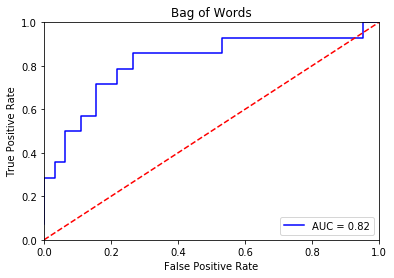

In [450]:
plt.title('Bag of Words')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [431]:
tags = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']
noun_tags = ['NN', 'NNS', 'NNP', 'NNPS']
verb_tags = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

In [432]:
len(tags)

35

In [410]:
def wc(st):
    return len(st.split(' '))
wc ('During chart QA, it was noticed that a 0.3cm')

9

In [411]:
def tag(st):
    return nltk.pos_tag(st.split())
tag('Missing info. on sim/ct sim sheet')

[('Missing', 'VBG'),
 ('info.', 'NN'),
 ('on', 'IN'),
 ('sim/ct', 'JJ'),
 ('sim', 'JJ'),
 ('sheet', 'NN')]

In [412]:
def this_tag(st, tl):
    return [w for (w, t) in tag(st) if t in tl]
this_tag('Missing info. on sim/ct sim sheet', ['NN'])

['info.', 'sheet']

In [413]:
def analyze(df, cls):
    for cl in cls:
        df[cl+'_wc'] = df[cl].apply(wc)
        df[cl+'_N'] = df[cl].apply(lambda x: len(this_tag(x, noun_tags)))
        df[cl+'_V'] = df[cl].apply(lambda x: len(this_tag(x, verb_tags)))
        for tag in tags:
            df[cl+'_'+tag] = df[cl].apply(lambda st: len(this_tag(st, [tag])))
    return df

In [414]:
analyzed = analyze(data, ['incident_description'])
analyzed

,ermi,event_type,incident_description,descriptor,coordinator_comments,investigation_narrative,acute_medical_harm,dosimetric_impact,latent_medical_harm,functional_work_area,...,incident_description_VB,incident_description_VBD,incident_description_VBG,incident_description_VBN,incident_description_VBP,incident_description_VBZ,incident_description_WDT,incident_description_WP,incident_description_WP$,incident_description_WRB
0,2511,Actual incident,Bolus was not prescribed by MD. Pt received 2 ...,Non prescribed bolus,NaN,NaN,None,Minor,No,TrueBeam 3,...,0,2,0,1,0,0,0,0,0,0
1,2521,Actual incident,Noticed by nutistionist (pt had app. with supp...,skin breakdown post RT,NaN,I handed over the investigation of incident to...,Mild,None,Unknown,STx 1,...,3,8,0,5,0,0,1,0,0,0
2,2562,Actual incident,"Ready for treatment task sent,completed,howeve...",Call patient task never sent,NaN,NaN,None,None,Unknown,STx 2,...,0,1,0,0,0,0,0,0,0,0
3,2560,Near miss,"Physics QA completed, but ready for treatment ...",ready for treatment tasking error,NaN,tasking error,NaN,NaN,NaN,Tasking,...,0,1,0,0,0,0,0,0,0,0
4,2526,Near miss,Typo in prescription document. It was prescrib...,prescription error,NaN,NaN,NaN,NaN,NaN,STx 2,...,0,1,0,1,0,0,0,0,0,0
5,2513,Actual incident,Started patient's treatments on a Friday inste...,New Start on Friday,NaN,NaN,None,None,Unknown,STx 1,...,0,0,1,1,0,0,0,0,0,0
6,2570,Actual incident,Pt was treated on TB 6on Feb 1st due to Tb3 be...,Lost vacloc,NaN,NaN,None,Minor,No,TrueBeam 6,...,2,1,1,2,0,0,0,0,0,0
7,2518,Near miss,Bolus not prescibed,Bolus,NaN,NaN,NaN,NaN,NaN,TrueBeam 3,...,0,0,0,1,0,0,0,0,0,0
8,2543,Actual incident,"Patient was lost(forgotten) in system, plan re...",Lack of adequate planning time.,NaN,patient lost in process,None,None,No,Treatment Planning,...,0,1,1,2,0,0,0,0,0,0
9,2541,Actual incident,Oncologist complained why patient was not cont...,Tasking Error,NaN,tasking error,None,None,No,Treatment Planning,...,0,3,1,2,0,0,0,0,0,1


In [415]:
analyzed['near_miss'] = analyzed['event_type'].apply(lambda x: 1 if x=='Near miss' else 0)

In [416]:
analyzed.corr()['near_miss']

ermi                           0.031837
patient_year_birth             0.045457
total_dose_prescribed         -0.047696
number_fractions_prescribed   -0.047033
number_fractions_incorrect          NaN
near_miss                      1.000000
incident_description_wc        0.164199
incident_description_N         0.126654
incident_description_V         0.114583
incident_description_CC        0.106061
incident_description_CD        0.015178
incident_description_DT        0.161103
incident_description_EX        0.122768
incident_description_FW       -0.029476
incident_description_IN        0.123657
incident_description_JJ        0.176470
incident_description_JJR      -0.023707
incident_description_JJS      -0.039680
incident_description_LS             NaN
incident_description_MD        0.023628
incident_description_NN        0.189157
incident_description_NNS       0.018969
incident_description_NNP       0.044286
incident_description_NNPS     -0.037941
incident_description_PDT      -0.043853


In [451]:
highest = ['incident_description_wc', 'incident_description_JJ', 'incident_description_NN']

In [452]:
features_train, features_test, y_train, y_test = train_test_split(data[features], data['near_miss'], test_size=0.15, random_state=1)

clf = LinearRegression()
clf.fit(features_train, y_train)

predictions = clf.predict(features_test)
predictions[:30]

array([ 0.57582446,  0.22172683,  0.12248361,  0.14946333,  0.19923351,
        0.07066933,  0.34540212, -0.11094174,  0.10024805,  0.18203001,
        0.19887   ,  0.3445699 ,  0.04598357,  0.0509918 ,  0.23011226,
        0.23371673,  0.15572621,  0.22873736,  0.04951928,  0.1459995 ,
        0.17777284,  0.37061609,  0.20991914,  0.23911374,  0.79303709,
        0.25464224, -0.34551462, -0.16082238,  0.11991736,  0.40846552])

In [453]:
roc_auc = roc_auc_score(y_test, predictions)
roc_auc

0.69754464285714279

In [454]:
fpr, tpr, threshold = roc_curve(y_test, predictions)

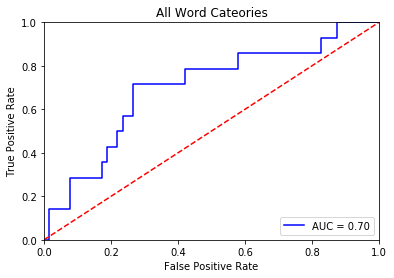

In [455]:
plt.title('All Word Cateories')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [422]:
features_train, features_test, y_train, y_test = train_test_split(data[['incident_description_NN']], data['near_miss'], test_size=0.15, random_state=1)

clf = LinearRegression()
clf.fit(features_train, y_train)

predictions = clf.predict(features_test)
predictions[:30]

array([ 0.12283073,  0.18901914,  0.18901914,  0.13937783,  0.17247203,
        0.13937783,  0.20556624,  0.12283073,  0.20556624,  0.18901914,
        0.15592493,  0.22211334,  0.17247203,  0.18901914,  0.12283073,
        0.13937783,  0.17247203,  0.22211334,  0.17247203,  0.12283073,
        0.18901914,  0.17247203,  0.12283073,  0.18901914,  0.42067854,
        0.20556624,  0.37103724,  0.22211334,  0.13937783,  0.12283073])

In [423]:
roc_auc = roc_auc_score(y_test, predictions)
roc_auc

0.6746651785714286

In [424]:
fpr, tpr, threshold = roc_curve(y_test, predictions)

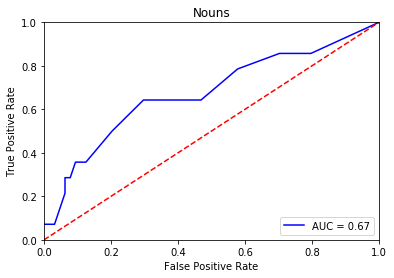

In [425]:
plt.title('Nouns')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [426]:
features_train, features_test, y_train, y_test = train_test_split(data[highest], data['near_miss'], test_size=0.15, random_state=1)

clf = LinearRegression()
clf.fit(features_train, y_train)

predictions = clf.predict(features_test)
predictions[:30]

array([ 0.18198114,  0.18101442,  0.17692646,  0.12596566,  0.15837596,
        0.13550424,  0.20297155,  0.12202439,  0.20637818,  0.16231723,
        0.16866396,  0.21985802,  0.15088137,  0.16981182,  0.12611235,
        0.19121584,  0.16208396,  0.24536848,  0.17639182,  0.11998041,
        0.1589106 ,  0.15224402,  0.12747501,  0.18812905,  0.47404078,
        0.2043342 ,  0.38334027,  0.18995824,  0.13346026,  0.13905756])

In [427]:
roc_auc = roc_auc_score(y_test, predictions)
roc_auc

0.7042410714285714